In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import random
import os
import shutil 
import time
import copy

from tqdm import tqdm   # Progress bar iterator

import torch
import torchvision
from torchvision import transforms, models

random.seed(55)
np.random.seed(55)
torch.manual_seed(55)
torch.cuda.manual_seed(55)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Any results you write to the current directory are saved as output.
print(os.listdir("../input"))

['plates']


In [2]:
# Если что-то осталось после предыдущих запусков - удалим это
!rmdir train test val /s /q
# !rm -rf train val test

ЌҐ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© д ©«.


In [3]:
data_root = '../input/plates/plates'
print(os.listdir(data_root))

['test', 'train', 'val']


In [4]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

# Создали дерево каталогов (train/clean, train/dirty, val/clean, val/dirty)
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# Копируем картинки по нужным папкам (каждая шестая в validation)
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)

    for i, file_name in enumerate(tqdm(sorted(os.listdir(source_dir)))):
        dest_dir = os.path.join(train_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        
    # Временный кусок, удалить
    source_dir = os.path.join(data_root, 'val', class_name)
    for i, file_name in enumerate(tqdm(sorted(os.listdir(source_dir)))):
        dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
    source_dir = os.path.join(data_root, 'train', class_name)

#     source_dir = os.path.join(data_root, 'train', class_name)
#     for i, file_name in enumerate(tqdm(sorted(os.listdir(source_dir)))):
#         dest_dir = os.path.join(train_dir, class_name)
#         shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
#         if i % 6 == 0:  # Val делаем только для галочки, влиять ни на что не будет
#             dest_dir = os.path.join(val_dir, class_name)
#             shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

#     for i, file_name in enumerate(tqdm(sorted(os.listdir(source_dir)))):
#         if i % 6 != 0:
#             dest_dir = os.path.join(train_dir, class_name)
#         else:
#             dest_dir = os.path.join(val_dir, class_name)
#         shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 971.75it/s]


In [5]:
# Трансформации - приведение картинок к общему виду
# Normalize - Нужно отнять 3 константы от RGB и поделить на 3 другие константы
# См. мануал по ResNet на сайте PyTorch, там объяснено

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    #transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    #transforms.Grayscale(3),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Генерируем датасеты. Лейблы берутся из названия папки файла, а сами картинки приводятся к общему виду
# train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms) 

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
for i in range(4-1):
    temp_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, temp_dataset])

# То же самое для Validation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


# Создаём объекты - генераторы пакетов (батчей). num_workers - кол-во одновременных тредов


batch_size = 20


train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)   # num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)  # num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)
# N батчей из K картинок (K = N * batch_size)

(8, 160)

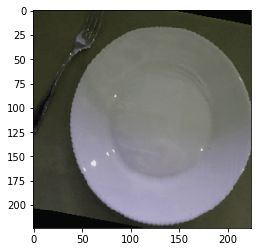

In [7]:
# Посмотрим на любой пример
# permute меняет местами измерения тензора

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

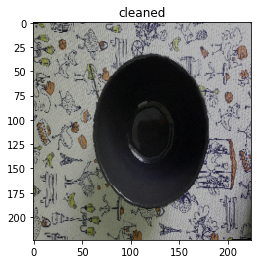

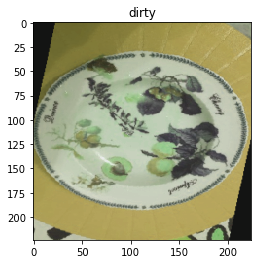

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

i = 2
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])
    i -= 1
    if i == 0:
        break

In [9]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
train_batch_loss_history = []
train_batch_accuracy_history = []
    
def train_model(model, loss, optimizer, scheduler, num_epochs):
    

    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch}/{num_epochs-1}: \n', end='')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader: # tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                train_batch_loss = loss_value.item()
                train_batch_accuracy = (preds_class == labels.data).float().mean().cpu().numpy().item()
                
                running_loss += train_batch_loss
                running_acc += train_batch_accuracy
                
                if phase == 'train':
                    train_batch_loss_history.append(train_batch_loss)
                    train_batch_accuracy_history.append(train_batch_accuracy)
                    # print(f'\r----- {phase}, batch accuracy {train_batch_accuracy * 100:.2f} %, batch loss {train_batch_loss:.4f}')        


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
                # scheduler.step()  - перенёс внутрь батча
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)               
                print(f'\n{phase}, accuracy {epoch_acc * 100:.2f} %, loss {epoch_loss:.4f}')        
    
    return model

In [10]:
# ResNet 18 - самый маленький (обычно берут 50)
model = models.mobilenet_v2(pretrained=True)

# Disable grad for all conv layers - замораживаем слои ResNet
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний слой на наш (512 входов, 2 выхода) (пересоздаём, поэтому будет разморожен)
#model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

# Кладём на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Бинарная кросс-энтропия
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) #, weight_decay=0.01, amsgrad=True)

# Decay LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # 512 / 32 = 16  (512 // batch_size * 16)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, milestones=[30,80], gamma=2)  

In [11]:
print(f'Batch size: {batch_size}\nBatches: {len(train_dataloader)}\nAll elements: {len(train_dataset)}')

Batch size: 20
Batches: 8
All elements: 160


In [12]:
# Тренировочка

train_model(model, loss, optimizer, scheduler, num_epochs=50);


Epoch 0/49: 

val, accuracy 49.75 %, loss 0.7150

Epoch 1/49: 

val, accuracy 77.00 %, loss 0.4436

Epoch 2/49: 

val, accuracy 88.50 %, loss 0.4102

Epoch 3/49: 

val, accuracy 88.25 %, loss 0.4062

Epoch 4/49: 

val, accuracy 89.50 %, loss 0.4049

Epoch 5/49: 

val, accuracy 89.25 %, loss 0.4040

Epoch 6/49: 

val, accuracy 89.00 %, loss 0.4060

Epoch 7/49: 

val, accuracy 88.75 %, loss 0.4045

Epoch 8/49: 

val, accuracy 89.75 %, loss 0.4035

Epoch 9/49: 

val, accuracy 89.00 %, loss 0.4068

Epoch 10/49: 

val, accuracy 88.50 %, loss 0.4047

Epoch 11/49: 

val, accuracy 89.50 %, loss 0.4036

Epoch 12/49: 

val, accuracy 89.75 %, loss 0.4044

Epoch 13/49: 

val, accuracy 89.50 %, loss 0.4023

Epoch 14/49: 

val, accuracy 89.25 %, loss 0.4050

Epoch 15/49: 

val, accuracy 90.00 %, loss 0.4002

Epoch 16/49: 

val, accuracy 89.50 %, loss 0.3984

Epoch 17/49: 

val, accuracy 89.75 %, loss 0.3992

Epoch 18/49: 

val, accuracy 88.75 %, loss 0.4015

Epoch 19/49: 

val, accuracy 89.25 %, lo

KeyboardInterrupt: 

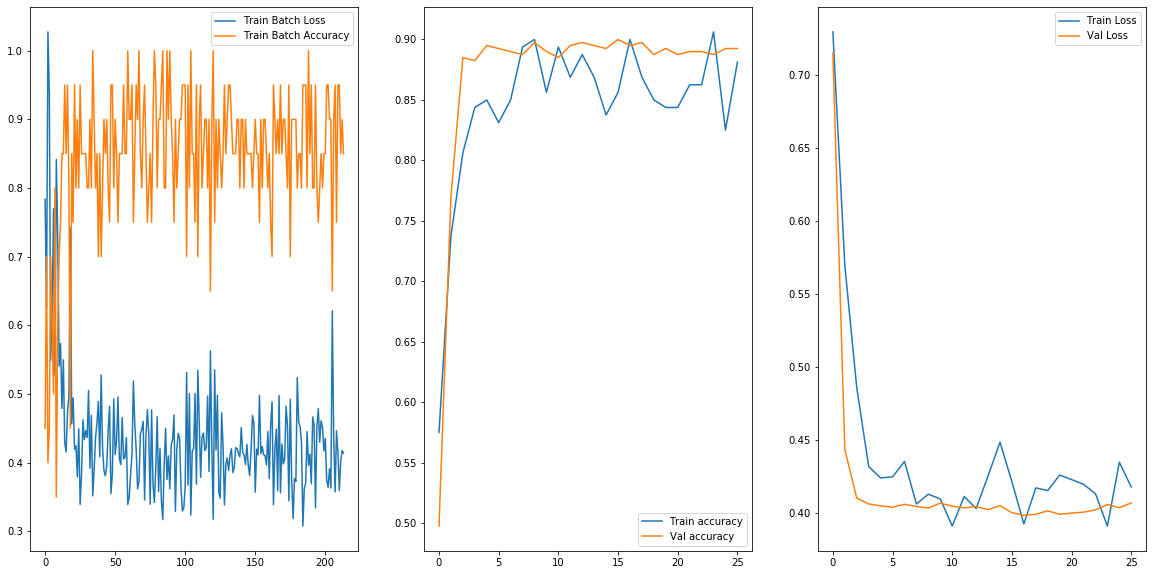

In [13]:
plt.figure(figsize=(20,10))
    
plt.subplot(1, 3, 1)
plt.plot(train_batch_loss_history, label='Train Batch Loss')
plt.plot(train_batch_accuracy_history, label='Train Batch Accuracy')
plt.legend();

plt.subplot(1, 3, 2)
plt.plot(train_accuracy_history, label='Train accuracy')
plt.plot(val_accuracy_history, label='Val accuracy')
plt.legend();
    
plt.subplot(1, 3, 3)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend();

In [ ]:
print(train_accuracy_history[-1], train_loss_history[-1])

# epoch-4
# 0.9445, 0.2470
# 0.9457  0.2348
# 0.9519  0.2105 2.5
# 0.9542  0.1929 3
# 0.9601  0.1702 4
# 0.9667  0.1363 8
# 0.9640  0.1284 12

# 0.9644  0.1210 16

# 0.9621  0.1244 20
# 0.9621  0.1244 24
# 0.9621  0.1244 32

# ------
# epoch-5

# 0.9687  0.1188 16


In [ ]:
STOP 666

In [ ]:
# Создадим новую папку и скопируем туда тестовый датасет

test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'));

In [ ]:
# Загружаем тестовый датасет из папки test_dir, применяем трансформации (те же, что и у validation dataset)
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)

# Конвертируем в итератор с батчем
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
print(test_dir)
print(len(test_dataloader))

In [ ]:
# Посмотрим на картинки
X_batch, y_batch = next(iter(test_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title='unknown')

In [ ]:
model.eval()

test_predictions = []
#test_img_paths = []
i = 1

for inputs, labels in test_dataloader:
    # paths
    inputs = inputs.cuda()
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    print(f'\r{i}/{len(test_dataloader)}', end='')
    i+=1
    #test_img_paths.extend(next(test_files_iter))
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
inputs, labels = next(iter(test_dataloader))

# for img, pred in zip(inputs, test_predictions):
#     show_input(img, title=pred)

In [ ]:
# Получаем список файлов из каталога test/unknown. 
# os.walk возвращает кортеж (каталог, имена подкаталогов, список файлов). Нам нужен список файлов [2]
test_files = next(iter(os.walk(os.path.join(test_dir, 'unknown'))))[2]

# Переделываем в спиок меток (отбрасываем '.jpg')
for i, file in enumerate(test_files):
    test_files[i] = test_files[i].split('.')[0]

print(test_files[:10])

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_files, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(25)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rmdir train test val /s /q
# !rm -rf train val test